In [60]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Flatten, LeakyReLU, BatchNormalization, Dropout
from keras.activations import relu, sigmoid
from keras.layers import LeakyReLU
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

In [2]:
dataset = pd.read_csv('datasets/Churn_Modelling.csv')
X = dataset.iloc[:, 3:13]
y = dataset.iloc[:, 13]
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


In [3]:
y

0       1
1       0
2       1
3       0
4       0
       ..
9995    0
9996    0
9997    1
9998    1
9999    0
Name: Exited, Length: 10000, dtype: int64

## Step 1 : Train Test Split

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Step 2 : Data Preprocessing 

In [5]:
# Encoding categorical features
X_train = pd.get_dummies(X_train, columns=['Gender', 'Geography'])
X_test = pd.get_dummies(X_test, columns=['Gender', 'Geography'])

In [6]:
# check that we have same nr of features in train and test set after one-hot encoding
print(X_train.shape)
print(X_test.shape)

(8000, 13)
(2000, 13)


In [7]:
# Feature Scaling

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Step 3 : Create a base model using KerasClassifier from Tensorflow Scikitlearn

In [84]:
def create_model(layers = [4,5,3], optimizer='adam', activation='relu', kernel_init='glorot_uniform', bias_init='zeros', loss='binary_crossentropy',
                 metrics=['accuracy']):
    
    model = Sequential()
    for i, node in enumerate(layers):
        if i==0:
            model.add(Dense(node, kernel_initializer=kernel_init, bias_initializer=bias_init,
                            input_dim=X_train.shape[1]))
            model.add(Activation(activation))
        else:
            model.add(Dense(node, kernel_initializer=kernel_init, bias_initializer=bias_init))
            model.add(Activation(activation))
            
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

In [85]:
base_model = KerasClassifier(build_fn=create_model, verbose=0)
base_model

In [86]:
base_model_history = base_model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=100, verbose=True)

Epoch 1/100
250/250 [==============================] - 0s 986us/step - loss: 0.5982 - accuracy: 0.7834 - val_loss: 0.5240 - val_accuracy: 0.7975
Epoch 2/100
250/250 [==============================] - 0s 609us/step - loss: 0.4934 - accuracy: 0.7960 - val_loss: 0.4669 - val_accuracy: 0.7975
Epoch 3/100
250/250 [==============================] - 0s 658us/step - loss: 0.4536 - accuracy: 0.7961 - val_loss: 0.4399 - val_accuracy: 0.7975
Epoch 4/100
250/250 [==============================] - 0s 613us/step - loss: 0.4361 - accuracy: 0.8018 - val_loss: 0.4267 - val_accuracy: 0.8200
Epoch 5/100
250/250 [==============================] - 0s 612us/step - loss: 0.4266 - accuracy: 0.8156 - val_loss: 0.4178 - val_accuracy: 0.8245
Epoch 6/100
250/250 [==============================] - 0s 632us/step - loss: 0.4208 - accuracy: 0.8223 - val_loss: 0.4130 - val_accuracy: 0.8245
Epoch 7/100
250/250 [==============================] - 0s 620us/step - loss: 0.4168 - accuracy: 0.8246 - val_loss: 0.4078 - val_ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


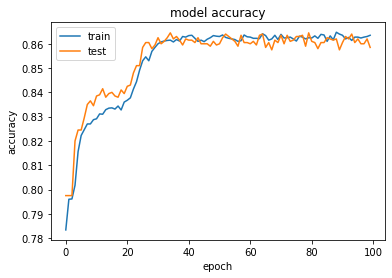

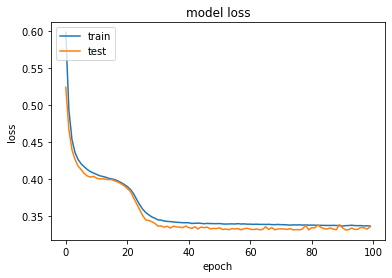

In [87]:
# list all data in history

print(base_model_history.history.keys())
# summarize history for accuracy
plt.plot(base_model_history.history['accuracy'])
plt.plot(base_model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(base_model_history.history['loss'])
plt.plot(base_model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [88]:
from sklearn.metrics import classification_report

In [89]:
# score returns the accuracy
base_model.score(X_test, y_test)

0.8585000038146973

In [90]:
# Model Performance on TEST SET

print('.')
test_pred_prob = base_model.predict_proba(X_test)[:, 1]
test_pred = np.where(test_pred_prob > 0.5, 1, 0)
print(classification_report(y_test, test_pred))

.
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      1595
           1       0.69      0.56      0.61       405

    accuracy                           0.86      2000
   macro avg       0.79      0.75      0.76      2000
weighted avg       0.85      0.86      0.85      2000



In [91]:
# Model Performance on TRAINING SET

train_pred_prob = base_model.predict_proba(X_train)[:, 1]
train_pred = np.where(train_pred_prob > 0.5, 1, 0)
print(classification_report(y_train, train_pred))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      6368
           1       0.73      0.52      0.61      1632

    accuracy                           0.86      8000
   macro avg       0.81      0.74      0.76      8000
weighted avg       0.85      0.86      0.85      8000



## Step 4 : Hyperparameter Tuning using RandomizedSearchCV 

* create_model is a function that design a NN model which will be used for hyperparameter tuning

In [92]:
def create_model(layers=[4,5,3], activation='relu', optimizer='adam', kernel_init='glorot_uniform', bias_init='zeros',
                 loss='binary_crossentropy', metrics=['accuracy']):
    
    model = Sequential()
    for i, node in enumerate(layers):
        if i==0:
            model.add(Dense(node, kernel_initializer=kernel_init, bias_initializer=bias_init,
                            input_dim=X_train.shape[1]))
            model.add(Activation(activation))
        else:
            model.add(Dense(node, kernel_initializer=kernel_init, bias_initializer=bias_init))
            model.add(Activation(activation))
    model.add(Dense(1)) # Note: no activation beyond this point
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

In [93]:
model = KerasClassifier(build_fn=create_model, verbose=0)
model

In [95]:
# [20] means one layer with 20 neurons, [40,20] means 2 layers with 40 and 20 neurons etc.

layers = [(20,), (40, 20), (45, 30, 15)]
activations = ['relu', 'sigmoid']
batch_sizes = [128, 256]
epochs = [30, 60]
param_grid = dict(layers=layers, activation=activations, batch_size=batch_sizes, epochs=epochs)
search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=10, scoring='accuracy', cv=5, n_jobs=-1)
search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x0000027808DA4F70>,
                   n_jobs=-1,
                   param_distributions={'activation': ['relu', 'sigmoid'],
                                        'batch_size': [128, 256],
                                        'epochs': [30, 60],
                                        'layers': [(20,), (40, 20),
                                                   (45, 30, 15)]},
                   scoring='accuracy')

In [96]:
[search.best_score_, search.best_params_, search.best_estimator_]

[0.84975,
 {'layers': (45, 30, 15),
  'epochs': 30,
  'batch_size': 128,
  'activation': 'relu'},

In [97]:
tuned_model = search.best_estimator_
tuned_model_history = tuned_model.fit(X_train, y_train, validation_data=(X_test, y_test), verbose=True)

Epoch 1/30
63/63 [==============================] - 0s 2ms/step - loss: 2.0134 - accuracy: 0.7955 - val_loss: 0.5432 - val_accuracy: 0.7965
Epoch 2/30
63/63 [==============================] - 0s 1ms/step - loss: 0.4989 - accuracy: 0.7968 - val_loss: 0.4917 - val_accuracy: 0.7990
Epoch 3/30
63/63 [==============================] - 0s 916us/step - loss: 0.4693 - accuracy: 0.7983 - val_loss: 0.4796 - val_accuracy: 0.8000
Epoch 4/30
63/63 [==============================] - 0s 883us/step - loss: 0.4512 - accuracy: 0.8015 - val_loss: 0.4567 - val_accuracy: 0.8035
Epoch 5/30
63/63 [==============================] - 0s 1ms/step - loss: 0.4367 - accuracy: 0.8102 - val_loss: 0.4345 - val_accuracy: 0.8200
Epoch 6/30
63/63 [==============================] - 0s 1ms/step - loss: 0.4175 - accuracy: 0.8166 - val_loss: 0.4056 - val_accuracy: 0.8270
Epoch 7/30
63/63 [==============================] - 0s 1ms/step - loss: 0.4026 - accuracy: 0.8305 - val_loss: 0.3917 - val_accuracy: 0.8445
Epoch 8/30
63/63

In [98]:
# Model Performance on TEST SET

#loss_test, accuracy_test = tuned_classifier.evaluate(X_test, y_test)
#print(f'Test Loss : {loss_test}')
#print(f'Test Accuracy : {accuracy_test}')

test_pred_prob = tuned_model.predict(X_test)
test_pred = np.where(test_pred_prob > 0.5, 1, 0)
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1595
           1       0.74      0.50      0.60       405

    accuracy                           0.86      2000
   macro avg       0.81      0.73      0.76      2000
weighted avg       0.85      0.86      0.85      2000



In [99]:
# Model Performance on TRAINING SET

train_pred_prob = tuned_model.predict_proba(X_train)[:, 1]
train_pred = np.where(train_pred_prob > 0.5, 1, 0)
print(classification_report(y_train, train_pred))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      6368
           1       0.77      0.48      0.59      1632

    accuracy                           0.86      8000
   macro avg       0.82      0.72      0.76      8000
weighted avg       0.86      0.86      0.85      8000

